In [1]:
import numpy as np
import pandas as pd

mu = 3.986005e14 # Standard Gravitational Parameter
a_earth = 6378.137e3  # Earth's semi-major axis in meters
b_earth = 6356.752e3  # Earth's semi-minor axis in meters
c = 2.99792458e8 # Speed of light
f_c = 1227e6 # L2_C carrier frequency
sv = pd.read_csv("JPL_March9th_selected_satellite_nav_data.csv")
# I went into the csv and corrected the typo in "pseudorange"

  Satellite  eccentricity       sqrt_a     Omega         i     omega  \
0       g05      0.005608  5153.761833 -2.114257  0.975223  1.317618   
1       g11      0.001702  5153.626839 -3.067863  0.966063 -2.341240   
2       g12      0.009010  5153.718182  1.144029  0.960435  1.486989   
3       g18      0.004865  5153.703934 -3.094519  0.974258 -2.942318   
4       g25      0.012368  5153.649990  1.054183  0.948628  1.120654   
5       g28      0.000309  5153.572697 -0.002007  0.961952  0.899407   

          M   pseudorange      Doppler  
0 -0.640409  2.065064e+07   495.387329  
1 -1.823699  2.407397e+07  3517.336317  
2  1.781971  2.261615e+07  3131.054023  
3 -2.997568  2.254488e+07 -2934.277242  
4  1.649285  2.086258e+07  1259.120678  
5  1.856906  2.448780e+07  -197.417799  


# From teaching staff: given potting function
Use these functions to plot your results in all the following parts.

In [2]:
# Graphing
import numpy as np
import matplotlib.pyplot as plt

def graph_constellation(tx_poses, rx_pos=None, tx_vels=None, rx_vel=None):
    """
    Plots the constellation of satellites in a 3D space.

    Parameters:
        tx_poses (dict): A dictionary where keys are satellite IDs and values are (x, y, z) coordinates.
        rx_pos (np.ndarray): R3 array of receiver position
        tx_vels (dict): A dictionary of satellite velocities
        rx_pos (np.ndarray): R3 array of receiver velocity
    """
    assert isinstance(tx_poses, dict), "Input must be a dictionary"
    if rx_pos is not None:
        assert isinstance(rx_pos, np.ndarray), "Input must be a numpy array"
        assert len(rx_pos) == 3, "rx_pos must be R3"
        if rx_vel is not None:
            assert isinstance(rx_vel, np.ndarray), "Input must be a numpy array"
            assert len(rx_vel) == 3, "rx_vel must be R3"
    # Ensure every entry in the dictionary has a valid 3D coordinate
    for sat, coord in tx_poses.items():
        assert isinstance(coord, (list, np.ndarray)), f"Value for {sat} must be a list or numpy array"
        assert len(coord) == 3, f"Value for {sat} must be a 3D coordinate (length 3), got {len(coord)}"


    # -------------------------
    # GPS Constellation Parameters (approximate)
    num_planes = 6                # number of orbital planes
    sats_per_plane = 4            # satellites per plane (total 24 satellites)
    semi_major_axis = 26561e3     # orbit radius in meters (approximate, circular orbit)
    inclination = np.deg2rad(55)  # orbital inclination in radians (~55°)
    
    # RAAN for each orbital plane (evenly spaced: 0, 60, 120, ..., 300 degrees)
    raan_list = [np.deg2rad(i * 60) for i in range(num_planes)]
    phase_offset = 0  # additional phase offset for satellites
    
    # -------------------------
    # Create the Earth sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x_earth = a_earth * np.outer(np.cos(u), np.sin(v))
    y_earth = a_earth * np.outer(np.sin(u), np.sin(v))
    z_earth = a_earth * np.outer(np.ones(np.size(u)), np.cos(v))
    
    # -------------------------
    # Set up the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the Earth (blue, semi-txparent)
    ax.plot_surface(x_earth, y_earth, z_earth, color='b', alpha=0.3, rstride=4, cstride=4, linewidth=0)
    
    # -------------------------
    # Plot the GPS constellation orbits and satellites
    # For each orbital plane, generate a full circle and plot the satellites
    for raan in raan_list:
        # Create a full circle for the orbit
        theta_circle = np.linspace(0, 2 * np.pi, 200)
        x_orb = semi_major_axis * np.cos(theta_circle)
        y_orb = semi_major_axis * np.sin(theta_circle)
        # txform from orbital plane to ECEF coordinates
        X_circle = np.cos(raan) * x_orb - np.sin(raan) * np.cos(inclination) * y_orb
        Y_circle = np.sin(raan) * x_orb + np.cos(raan) * np.cos(inclination) * y_orb
        Z_circle = np.sin(inclination) * y_orb
        ax.plot(X_circle, Y_circle, Z_circle, color='g', linestyle='-', linewidth=1)
    
    # -------------------------
    for name, tx_poses in tx_poses.items():
        
        # Plot the velocity arrow using quiver
        ax.scatter(tx_poses[0], tx_poses[1], tx_poses[2], s=100, label=f'Satellite ID {name}')
        if tx_vels is not None:
            ax.quiver(tx_poses[0], tx_poses[1], tx_poses[2],
                  tx_vels[name][0], tx_vels[name][1], tx_vels[name][2],
                  length=1e3, color='r', arrow_length_ratio=0.3)
    if rx_pos is not None:
        ax.scatter(rx_pos[0],rx_pos[1], rx_pos[2], s=100, label='receiver')
        if rx_vel is not None:
            ax.quiver(rx_pos[0], rx_pos[1], rx_pos[2],
                  200 *rx_vel[0], 200 * rx_vel[1], 200* rx_vel[2],
                  length=1e3, color='r', arrow_length_ratio=0.3)
    
    # -------------------------
    # Set plot limits and labels
    limit = 3e7  # 30 million meters
    ax.set_xlim([-limit, limit])
    ax.set_ylim([-limit, limit])
    ax.set_zlim([-limit, limit])
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('GPS Constellation Orbits and Satellite tx_posess')
    ax.view_init(elev=40, azim=80)
    ax.legend()
    plt.show()

# Part C: Plot position of 5 satellites in ECEF coordinate system
Use what we have learned in class and what you derived in part a and b to create a function which given any of these satellites, finds the position in ECEF coordinates of the satellite.

Remember this is ephemeris data transmitted by each of these satellites.

After finding each of the positions use the provided function graph_constellation to plot each of the satellites on the orbitals.

## Helper Functions

In [3]:
def z_rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta),  0],
        [0,             0,              1]
    ])

def x_rotation_matrix(theta):
    return np.array([
        [1,  0,             0],
        [0,  np.cos(theta), -np.sin(theta)],
        [0,  np.sin(theta),  np.cos(theta)]
    ])

## My Solution
* Start with the ephemeris data broadcast by the satellites (e, a, i, Ω, ω, M).
* Use the mean anomaly (M) and solve for the eccentric anomaly (E) using the Newton-Raphson method.
* With E, compute the true anomaly (ν) and radial distance (r) in the orbital plane.
* These calculations for r and ν allow us to plug in and find the position (x_orb, y_orb) in the orbital plane.
* Apply the three rotations to transform the orbital coordinates into ECEF (R = Rz (Ω) Rx(i) Rz (ω)).
* This gives the position (x, y, z) of the satellite in the ECEF frame.
* Repeat for each satellite and plot using the provided `graph_constellation()` function.


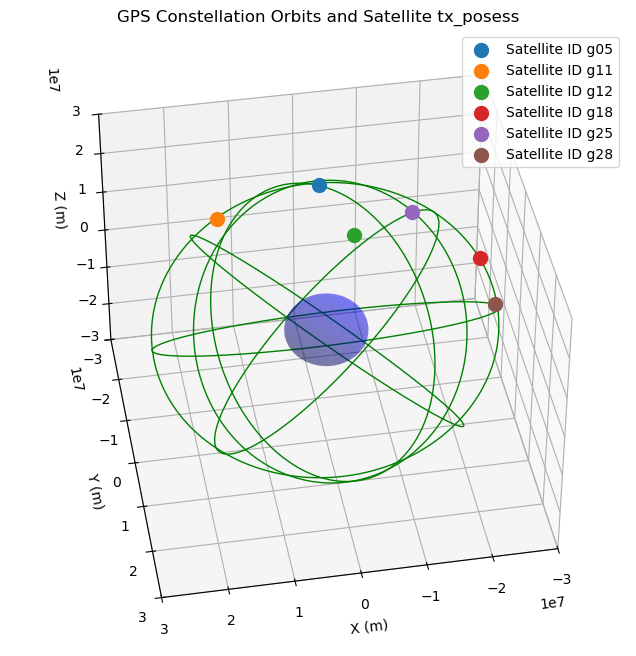

In [4]:
"""
The ephemeris data for each satellite from the csv is broken down into 
a list of elements, where each element is a dictionary of each satellite's
orbital parameters. 

This way, each satellite in the list's ephemeris data can be easily accessed like this:
    sat['id'], sat['a']

Also, since 'a' is stored as the square root of a, it is squared it to avoid any mathematical
errors later on in different functions.
"""
ephemerides = [
    {
      "id":    row.Satellite,
      "e":     row.eccentricity,
      "a":     (row.sqrt_a)**2, 
      "Omega": row.Omega,
      "i":     row.i,
      "omega": row.omega,
      "M":     row.M,
      "pseudorange": row.pseudorange,
      "doppler": row.Doppler
    }
    for _, row in sv.iterrows()
]

""" 
Newton–Raphson iterative solver for Kepler’s equation, given e and M.

Steps: 
1) Choose an initial guess E_0
2) Compute the next approximation E_new, using the formula 
    E_new = E_0 — [f(E_0) / f’(E_0)]. 
    Here f’(E) is derivative of f(E) at E_0
3) Loop to update the guess 
4) Stop once it converges or reaches max iterations

"""
def solve_kepler(M,e,tol,max_iter):
    E_0 = M
    for t in range(max_iter):
        f = E_0 - e*np.sin(E_0)-M
        f_prime = 1 - e*np.cos(E_0)
        E_new = E_0 - f / f_prime
        if abs(E_new - E_0) < tol: # Check convergence
            # print(f"Converged in {t} iterations")
            return E_new
        E_0 = E_new
    raise RuntimeError("Did not converge within {max_iter} iterations!")
    
""" 
Calculates an expression for r, the distance of the satellite from the center of the Earth 
in terms of orbital parameters (a,e,E), as derived in Part a of Question 3.
"""
def find_r(a,e,E):
    return a*(1-e*np.cos(E))

def find_cosv(e,E):
    return (np.cos(E)-e)/(1-e*np.cos(E))

def find_sinv(e,E):
    return np.sqrt(1 - e**2) * np.sin(E) / (1 - e*np.cos(E))

""" 
Calculates the final 3x1 vector of the satellite's orbital position, given r, cos(nu), sin(nu).
"""
def sat_pos_orb(r,c_nu,s_nu):
    return np.array([r * c_nu, r * s_nu, 0.0])

""" 
Translates the 2D orbital coordinates of satellite's position into ECEF position used for maps, GPS
receiver positions, etc because it rotates with the earth as it moves.
"""
def ref_frame_conversion(omega1,inclination, omega2, sat_pos_orb):
     return z_rotation_matrix(omega1) @ x_rotation_matrix(inclination) @ z_rotation_matrix(omega2) @ sat_pos_orb

tx_poses = {}
for sat in ephemerides:
    E = solve_kepler(sat["M"], sat["e"], tol=1e-10, max_iter=10)
    r = find_r(sat["a"],sat["e"],E) 
    c_nu = find_cosv(sat["e"],E)
    s_nu = find_sinv(sat["e"],E)
    position = sat_pos_orb(r,c_nu,s_nu)
    final_pos = ref_frame_conversion(sat["Omega"],sat["i"], sat["omega"], position)
    tx_poses[sat["id"]] = final_pos

graph_constellation(tx_poses)
# print(tx_poses)


# Part D: Find Position and Clock Bias of the Receiver

Use the pseudoranges provided for the 5 satellites to find and report the receiver’s position and clock bias. Give the geodetic coordinates (long, lat, alt). 

## Given helper functions

In [5]:
# Convert Geodetic Coords (degrees) to ECEF (meters)
def geo_to_ecef_vec(vec):
    return geo_to_ecef(vec[0],vec[1],vec[2])
def geo_to_ecef(lat_deg, long_deg, alt_m):
    lat_rad = lat_deg*np.pi/180
    long_rad = long_deg*np.pi/180

    esqrd = 1 - (b_earth**2 / a_earth**2)
    N = a / np.sqrt(1-esqrd*np.sin(lat_rad)**2)
    
    x_ecef = (N+alt_m)*np.cos(lat_rad)*np.cos(long_rad)
    y_ecef = (N+alt_m)*np.cos(lat_rad)*np.sin(long_rad)
    z_ecef = ((N * b_earth**2) / a_earth**2 + alt_m)*np.sin(lat_rad)

    return np.array([x_ecef, y_ecef, z_ecef])

# Convert ECEF Coords (meters) to Geodetic (degrees) 
def ecef_to_geodetic_iterative_vec(vec):
    return ecef_to_geodetic_iterative(vec[0],vec[1],vec[2])
def ecef_to_geodetic_iterative(x_ecef, y_ecef, z_ecef, tol=1e-6, max_iter=10):
    e2 = 1 - (b_earth**2 / a_earth**2)  # First eccentricity squared

    # Compute longitude directly
    lon_rad = np.arctan2(y_ecef, x_ecef)

    # Compute preliminary values
    p = np.sqrt(x_ecef**2 + y_ecef**2)
    lat_rad = np.arctan2(z_ecef, p)  # Initial guess for latitude
    h = 0  # Initial altitude estimate

    iteration_count = 0

    # Iterative latitude refinement
    for i in range(max_iter):
        iteration_count += 1
        N = a_earth / np.sqrt(1 - e2 * np.sin(lat_rad)**2)  # Compute prime vertical radius
        new_h = p / np.cos(lat_rad) - N  # Update altitude
        new_lat_rad = np.arctan2(z_ecef + e2 * N * np.sin(lat_rad), p)  # Update latitude

        # Check for convergence
        if abs(new_lat_rad - lat_rad) < tol and abs(new_h - h) < tol:
            break

        lat_rad, h = new_lat_rad, new_h

    # Convert back to degrees
    lat_deg = np.degrees(lat_rad)
    lon_deg = np.degrees(lon_rad)

    return np.array([lat_deg, lon_deg, h])

## My Solution
Explain whether this location makes sense by
converting the ECEF position to geodetic coordinates and giving a google maps
image. Again, please plot using the function provided.

Computed receiver position (ECEF):
X: -2697599.16 m
Y: -4293181.66 m
Z: 3856464.72 m
Clock bias:  1.0011809502282406e-06

Geodetic coordinates:
Latitude: 37.441911°
Longitude: -122.142994°
Altitude: 29.12 m
Google Maps link: https://www.google.com/maps?q=37.44191141232263,-122.14299421918678


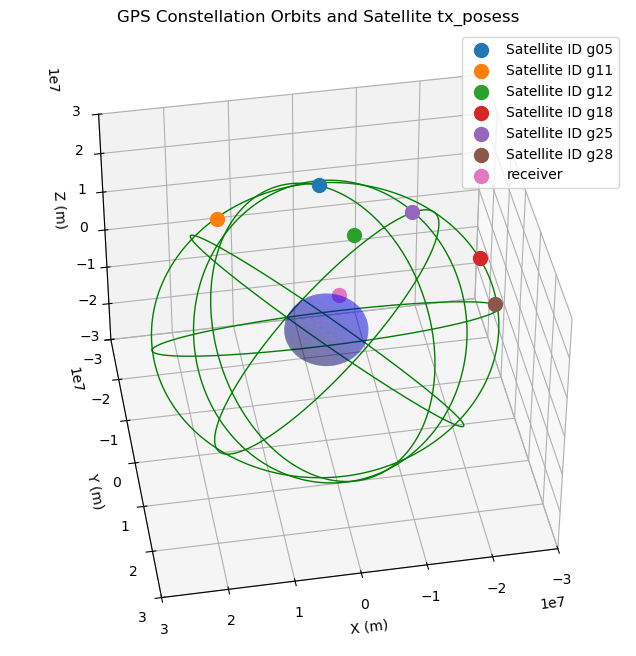

In [6]:
def find_receiver_position(satellites, pseudoranges, max_iter, tolerance):
    """
    Gauss-Newton solver for receiver position from pseudoranges.
    """
    x = np.array([0, 0, a_earth, 0])
    for iteration in range(max_iter):
        A = np.zeros((len(satellites), 4))
        b = np.zeros(len(satellites))
        
        for i, (sat_id, sat_pos) in enumerate(satellites.items()):
            dx = sat_pos[0] - x[0]
            dy = sat_pos[1] - x[1]
            dz = sat_pos[2] - x[2]
            rho = np.sqrt(dx**2 + dy**2 + dz**2)
            
            A[i, 0] = -dx / rho
            A[i, 1] = -dy / rho
            A[i, 2] = -dz / rho
            A[i, 3] = 1  
            
            b[i] = pseudoranges[sat_id] - (rho + x[3]) # Compute pseudorange residual
    
        delta_x = np.linalg.lstsq(A, b, rcond=None)[0]
        x = x + delta_x
        if np.linalg.norm(delta_x) < tolerance:
            break
    
    return x

pseudoranges = {sat["id"]: sat["pseudorange"] for sat in ephemerides}
receiver_position = find_receiver_position(tx_poses, pseudoranges, 20, 1e-6)
clock_bias = receiver_position[3]/c
geodetic_coords = ecef_to_geodetic_iterative_vec(receiver_position[:3]) # convert ECEF position to geodetic coordinates

print("Computed receiver position (ECEF):")
print(f"X: {receiver_position[0]:.2f} m")
print(f"Y: {receiver_position[1]:.2f} m")
print(f"Z: {receiver_position[2]:.2f} m")
print(f"Clock bias: ", clock_bias)

print("\nGeodetic coordinates:")
print(f"Latitude: {geodetic_coords[0]:.6f}°")
print(f"Longitude: {geodetic_coords[1]:.6f}°")
print(f"Altitude: {geodetic_coords[2]:.2f} m")

graph_constellation(tx_poses, receiver_position[:3])
plt.show()

print(f"Google Maps link: https://www.google.com/maps?q=37.44191141232263,-122.14299421918678")

# Part F: Estimating Receiver Velocity via Doppler Shift Analysis

- Use the Doppler shifts provided in the dataset and the satellite velocities 
  (computed for each of the 5 satellites).
- Combine this information with the receiver position from Part (d).
- Formulate and solve an overdetermined linear system to estimate the 
  velocity vector of the receiver.
- Use the provided plotting function to visualize the results.
- Report the final estimated receiver velocity.

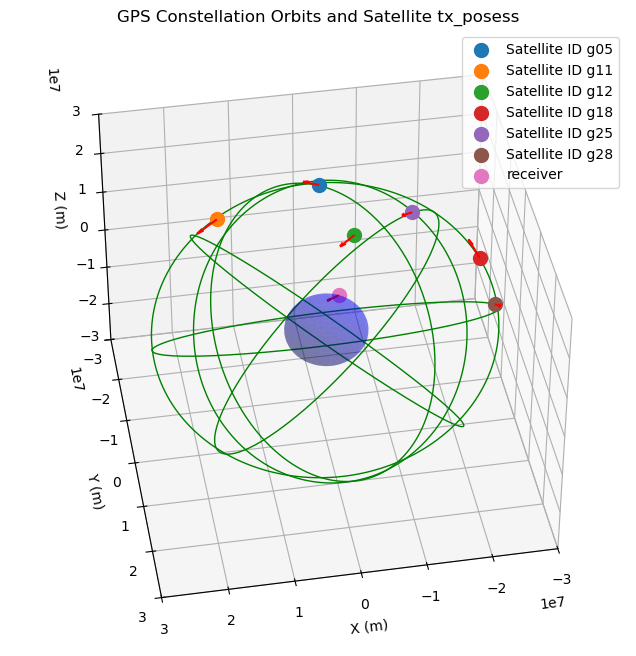

Estimated receiver velocity (m/s): [ 9.99987725e+00  5.00016150e+00 -9.78228402e-05]


In [7]:
def vel(a,e,E):
    """
    """
    vx = -np.sqrt(mu/a) * np.sin(E)/(1-e*np.cos(E))
    vy = np.sqrt(1-e**2) * np.sqrt(mu/a) * np.cos(E)/(1-e*np.cos(E))
    return np.array([vx, vy, 0])


tx_vels = {}
fd_dict = {}
for sat in ephemerides:
    E = solve_kepler(sat["M"], sat["e"], tol=1e-10, max_iter=50)
    v_orb = vel(sat["a"],sat["e"], E)
    v_eci = ref_frame_conversion(sat["Omega"], sat["i"], sat["omega"], v_orb)
    #print("magnitude of", sat["id"], ":", np.linalg.norm(v_eci))  # should be around 3900–4000 m/s
    tx_vels[sat["id"]] = v_eci
    fd_dict[sat["id"]] = sat["doppler"]
    

rx_pos = receiver_position[:3]

tx_poses_arr = np.array(list(tx_poses.values())) 
tx_vels_arr = np.array(list(tx_vels.values()))
doppler_arr = np.array(list(fd_dict.values()))  

relative_pos = rx_pos - tx_poses_arr
pos_unit_vec = relative_pos / np.linalg.norm(relative_pos, axis=1, keepdims=True)
A = pos_unit_vec
b = (doppler_arr * c) / f_c + np.sum(tx_vels_arr * pos_unit_vec, axis=1)
rx_vel = np.linalg.inv(A.T @ A) @ A.T @ b

graph_constellation(tx_poses, rx_pos, tx_vels, rx_vel)

print("Estimated receiver velocity (m/s):", rx_vel)
